In [1]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script for generic plots of ISSM output
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from scipy_io_utils import *

from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

import matplotlib.pyplot as plt
import numpy as np
import pickle

import pylab as pl


In [2]:
#filename = ''/efs/mpascual/SAtoES_hindcast_transient_low_retreat_end_member.nc'
#filename = './Models/SAtoES_hindcast_control_new_inversion_20221910.nc'
filename = './Models/SAtoES_hindcast_control_new_inversion_20222010.nc'

# Load model
md = loadmodel(filename, singleres='TransientSolution', resvars=['time', 'Thickness', 'Vel', 'MaskIceLevelset']) #, singletime=-1)

# Load glacier data
m = loadmat('./Cheat_matfiles/glacier0013.mat'); glacier0013 = m['glacier0013'];
m = loadmat('./Cheat_matfiles/glacier0052.mat'); glacier0052 = m['glacier0052'];
m = loadmat('./Cheat_matfiles/glacier0053.mat'); glacier0053 = m['glacier0053'];
m = loadmat('./Cheat_matfiles/glacier0090.mat'); glacier0090 = m['glacier0090'];

glaciers = [glacier0013, glacier0052, glacier0053, glacier0090]


Opening ./Models/SAtoES_hindcast_control_new_inversion_20222010.nc for reading 
empty init
solutionstep
solutionstep


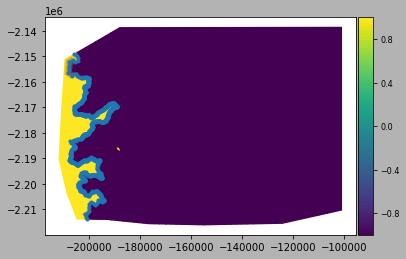

In [7]:
from contourlevelzero import contourlevelzero

contours = contourlevelzero(md, md.mask.ice_levelset, 0)

plotmodel(md, 'data', md.mask.ice_levelset)
plt.plot(contours[0]['x'], contours[0]['y'], '.-')


from expwrite import expwrite
expwrite(contours[0], 'test.exp')


Text(0.5, 0, 'thickness change (m)')

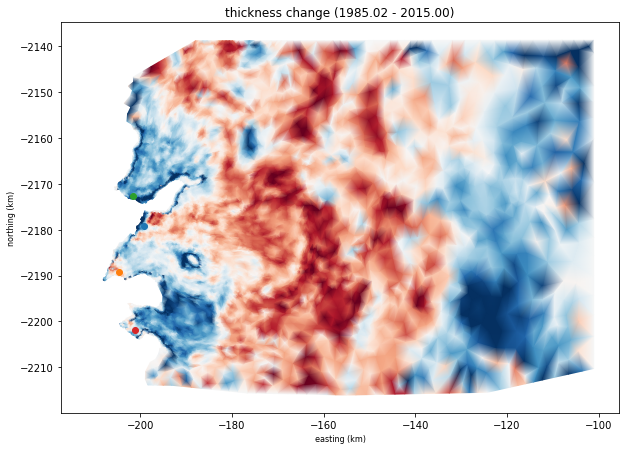

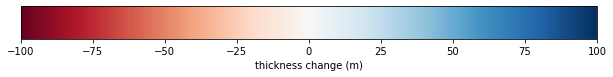

In [30]:
# Plot change in ice thickness
cmap = 'RdBu'

plot_step_start =  0
plot_step_end   = -1

thickness_change = md.results.TransientSolution[plot_step_end].Thickness - md.results.TransientSolution[plot_step_start].Thickness #md.geometry.thickness

fig = plt.figure(figsize=(10,10))
vmin = -100
vmax = +100
plotmodel(md, 'data', thickness_change, 'mask', md.results.TransientSolution[plot_step_end].MaskIceLevelset<=0, \
         'colormap', cmap, 'caxis', [vmin, vmax], 'colorbar', 'off', \
         'unit', 'km', 'xlabel', 'easting (km)', 'ylabel', 'northing (km)', \
         'backgroundcolor', 'white')

# for masking: 'mask#all', md.mask.ice_levelset<=0

plt.title('thickness change ({:6.2f} - {:6.2f})'.format(md.results.TransientSolution[plot_step_start].time[0], md.results.TransientSolution[plot_step_end].time[0]))

# Add glacier locations
# NOTE that we divide by 1000 to get units of km to match the plotmodel command above
for glacier in glaciers:
    plt.plot(glacier['x']/1000., glacier['y']/1000., 'o')
    
# Colorbar as a separate plot
a = np.array([[vmin,vmax]])
pl.figure(figsize=(10, 0.75))
img = pl.imshow(a, cmap=cmap)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation='horizontal', cax=cax)
pl.xlabel('thickness change (m)')


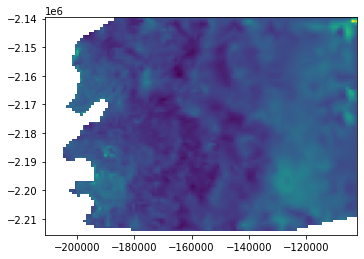

In [31]:
from scipy.interpolate import griddata

xstep = 1000
ystep = 1000
xi = np.arange(np.min(md.mesh.x),np.max(md.mesh.x),xstep)
yi = np.arange(np.min(md.mesh.y),np.max(md.mesh.y),ystep)

mask = md.results.TransientSolution[plot_step_end].MaskIceLevelset > 0
thickness_change[mask] = np.nan

xi,yi = np.meshgrid(xi,yi)
zi = griddata((md.mesh.x,md.mesh.y),thickness_change,(xi,yi),method='linear')

extent = [xi[0,0] + xstep/2, xi[0,-1] - xstep/2, yi[0,0] + ystep/2, yi[-1,0] - ystep/2]
plt.imshow(zi, extent=extent, origin='lower')

sys.path.append('/home/jovyan/scripts_and_utilities/pythonModules')
import raster

raster.writeArrayAsRasterBand('thickness_change.tif', raster.extent2gt(zi,extent), np.flipud(zi), -9999.)


In [ ]:
# Interpolate thickness from TransientSolution to glacier locations
from InterpFromMesh2d import InterpFromMesh2d

fig = plt.figure()
for glacier in glaciers:
    time = list()
    glacier_thickness = list()
    for i in range(len(md.results.TransientSolution)):
        thickness = InterpFromMesh2d(md.mesh.elements, md.mesh.x, md.mesh.y, md.results.TransientSolution[i].Thickness, \
                                     glacier['x'], glacier['y'])
        time.append(md.results.TransientSolution[i].time)
        glacier_thickness.append(thickness)
    
    plt.plot(time, glacier_thickness)

In [ ]:
from plotdoc import plotdoc
plotdoc()